In [ ]:
########################################################################################################################
# Filename: FF_Models_Training.ipynb
#
# Purpose: Multi-label Text-categorization via feed forward neural networks -- Train networks/generate results

# Author(s): Bobby (Robert) Lumpkin
#
# Library Dependencies: numpy, pandas, scikit-learn, skmultilearn, joblib, os, sys, threshold_learning
########################################################################################################################

# Multilabel Text Classification with Feed Forward Networks

In [5]:
import numpy as np
import pandas as pd
import math
import os
import json
import ast
import random
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from bpmll import bp_mll_loss
import sklearn_json as skljson
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import sys
os.chdir('C:\\Users\\rober\\OneDrive\\Documents\\Multilabel-Text-Classification\\Deep Learning Models\\FF Models')  ## Set working directory
                                                                                                                      ## to be 'ANN Results'
sys.path.append('../../ThresholdFunctionLearning')    ## Append path to the ThresholdFunctionLearning directory to the interpreters
                                                   ## search path
from threshold_learning import predict_test_labels_binary    ## Import the 'predict_test_labels_binary()' function from the 
from threshold_learning import predict_labels_binary         ## threshold_learning library
sys.path.append('GridSearchAid_FFNetworks')
from FFNN_gridSearch_aid import SizeLayersPows2, createModel

In [2]:
## Load the seperabe PCs training and test data
npzfile = np.load("../../Data/tfidf_PC_separable.npz")
X_sepPCs_train = npzfile['X_sepPCs_train']
X_sepPCs_test = npzfile['X_sepPCs_test']
Y_train = npzfile['Y_train'].astype('float64')
Y_test = npzfile['Y_test'].astype('float64')

## Load the autoencoder train/test features
npzfile = np.load('../../Data/tfidf_encoded_data.npz')
encoded_train = npzfile['encoded_train']
encoded_test = npzfile['encoded_test']

## Load the tfidf training and test data
npzfile = np.load("../../Data/tfidf_trainTest_data.npz", allow_pickle = True)
X_tfidfTrain = npzfile['X_tfidfTrain']
X_tfidfTest = npzfile['X_tfidfTest']

# Cross Entropy Models -- Traditional ("Naive") Approach


## Training on Dimension-Reduced Separable PC Vectors

In [32]:
## Perform small grid search to choose number of layers
model_dict = {}
history_dict = {}
for num_layers in [3, 4, 5]:
    model = createModel(X_sepPCs_train, 
                        num_layers, 
                        X_sepPCs_train.shape[0], 
                        Y_train.shape[1], 
                        activation_func = 'relu', 
                        output_activation = 'sigmoid', 
                        loss_func = 'binary_crossentropy')
    
    tf.random.set_seed(123)
    model_history = model.fit(X_sepPCs_train, Y_train, epochs = 30,
                              validation_data = (X_sepPCs_test, Y_test), verbose = 0)
    name = f"{num_layers}_layers"
    model_dict[name] = model
    history_dict[name] = model_history

In [33]:
## Convert the training histories to DFs for plotting
history_3 = history_dict['3_layers']
history_4 = history_dict['4_layers']
history_5 = history_dict['5_layers']
history_3DF = pd.DataFrame(history_3.history)
history_4DF = pd.DataFrame(history_4.history)
history_5DF = pd.DataFrame(history_5.history)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 1024)              34816     
_________________________________________________________________
dense_27 (Dense)             (None, 90)                92250     
Total params: 127,066
Trainable params: 127,066
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 2048)              69632     
_________________________________________________________________
dense_29 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_30 (Dense)             (None, 90)                46170     
Total params: 1,164,890


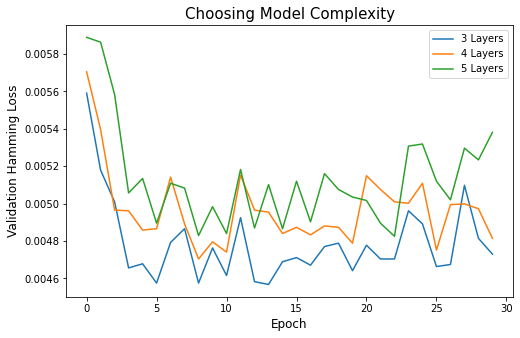

In [38]:
## Visualize the 'val_hamming_loss' histories for each model in a single plot
plt.figure(figsize=(8, 5))
plt.plot(history_3DF['val_hamming_loss'], label = '3 Layers')
plt.plot(history_4DF['val_hamming_loss'], label = '4 Layers')
plt.plot(history_5DF['val_hamming_loss'], label = '5 Layers')
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Validation Hamming Loss', fontsize = 12)
plt.legend()
plt.title('Choosing Model Complexity', fontsize = 15)
#plt.savefig('Reduced_Dataset_Learning_Rate_01.png')

## Print the model summaries
model_dict['3_layers'].summary()
model_dict['4_layers'].summary()
model_dict['5_layers'].summary()

In [40]:
## (CAUTION: DO NOT OVERWRITE EXISTING FILES) -- Convert training history to dataframe and write to a .json file 
#with open("Training Histories Layers GS/history_ce_FF_sepPCs_lr001.json", "w") as outfile: 
#    history_3DF.to_json(outfile)

## Training on Dimension-Reduced Autoencoder Feature Vectors

In [41]:
## Perform small grid search to choose number of layers
model_dict = {}
history_dict = {}
for num_layers in [3, 4, 5]:
    model = createModel(encoded_train, 
                        num_layers, 
                        encoded_train.shape[0], 
                        Y_train.shape[1], 
                        activation_func = 'relu', 
                        output_activation = 'sigmoid', 
                        loss_func = 'binary_crossentropy')
    
    tf.random.set_seed(123)
    model_history = model.fit(encoded_train, Y_train, epochs = 30,
                              validation_data = (encoded_test, Y_test), verbose = 0)
    name = f"{num_layers}_layers"
    model_dict[name] = model
    history_dict[name] = model_history

In [42]:
## Convert the training histories to DFs for plotting
history_3 = history_dict['3_layers']
history_4 = history_dict['4_layers']
history_5 = history_dict['5_layers']
history_3DF = pd.DataFrame(history_3.history)
history_4DF = pd.DataFrame(history_4.history)
history_5DF = pd.DataFrame(history_5.history)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 1024)              34816     
_________________________________________________________________
dense_36 (Dense)             (None, 90)                92250     
Total params: 127,066
Trainable params: 127,066
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 2048)              69632     
_________________________________________________________________
dense_38 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_39 (Dense)             (None, 90)                46170     
Total params: 1,164,890


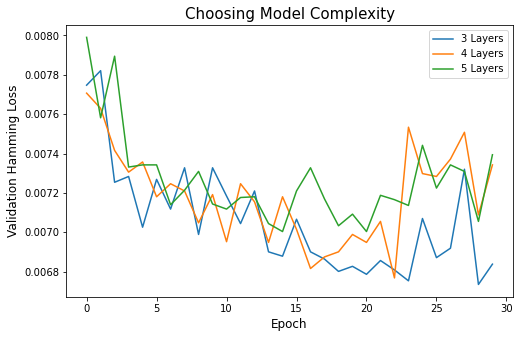

In [43]:
## Visualize the 'val_hamming_loss' histories for each model in a single plot
plt.figure(figsize=(8, 5))
plt.plot(history_3DF['val_hamming_loss'], label = '3 Layers')
plt.plot(history_4DF['val_hamming_loss'], label = '4 Layers')
plt.plot(history_5DF['val_hamming_loss'], label = '5 Layers')
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Validation Hamming Loss', fontsize = 12)
plt.legend()
plt.title('Choosing Model Complexity', fontsize = 15)
#plt.savefig('Reduced_Dataset_Learning_Rate_01.png')

## Print the model summaries
model_dict['3_layers'].summary()
model_dict['4_layers'].summary()
model_dict['5_layers'].summary()

In [44]:
## (CAUTION: DO NOT OVERWRITE EXISTING FILES) -- Convert training history to dataframe and write to a .json file 
#with open("Training Histories Layers GS/history_ce_FF_encoded_lr001.json", "w") as outfile: 
#    history_3DF.to_json(outfile)

# BPMLL Models -- "Novel" Approach

## Training on Dimension-Reduced Separable PC Vectors

In [ ]:
## Perform small grid search to choose number of layers
model_dict = {}
history_dict = {}
for num_layers in [3, 4, 5]:
    model = createModel(X_sepPCs_train, 
                        num_layers, 
                        X_sepPCs_train.shape[0], 
                        Y_train.shape[1], 
                        activation_func = 'relu', 
                        output_activation = 'sigmoid', 
                        loss_func = bp_mll_loss)
    
    tf.random.set_seed(123)
    model_history = model.fit(X_sepPCs_train, Y_train, epochs = 30,
                              validation_data = (X_sepPCs_test, Y_test), verbose = 0)
    name = f"{num_layers}_layers"
    model_dict[name] = model
    history_dict[name] = model_history